# HackDartmouth IV - QSS Data Science Challenge
In this notebook, we will load the training data and perform preliminary processing and analysis before we start training. 

From the challenge prompt, we know the following:
- Development set: 749,575 Yelp reviews
- Evaluation set: 250,425 Yelp reviews
- Challenge: predict **review star ratings**
- Avaliable features:
    + business_id
    + cool
    + date
    + funny
    + review_id
    + text
    + useful
    + user_id

In [37]:
# Basic Imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
## Load Dataset
fname = 'yelp.json'
df    = pd.read_json('yelp.json')

print 'Total number of entries: {}'.format(len(df))

Total number of entries: 749574


### Notes on Features
- **review_id**: all review ids are unique, hence can remove entire column
- **business_id**: only 123,553 unique entries
- **user_id**: only 221,465 unique entries

In [4]:
# Convert Select Cols to categories 
catcols = ['business_id','user_id']
for col in catcols:
    df[col] = df[col].astype('category')

In [5]:
df['user_id'] = df.user_id.cat.codes
df['business_id'] = df.business_id.cat.codes

In [6]:
# Include Normalized Date
# Using month, day & year
df['month'] = df.date.dt.month
df['day']   = df.date.dt.day
df['year']  = df.date.dt.year
df['dOw']   = df.date.dt.dayofweek
df.drop(columns=['date'])

cols  = ['business_id','user_id','review_id',
         'year','month','day','dOw','cool',
         'funny','useful','text','stars']
df    = df[cols]

In [7]:
df.head()

,business_id,user_id,review_id,year,month,day,dOw,cool,funny,useful,text,stars
0,2956,138470,v0i_UHJMo_hPBq9bxWvW4w,2016,5,28,5,0,0,0,"Love the staff, love the meat, love the place....",5
1,21735,138470,vkVSCC7xljjrAI4UGfnKEQ,2016,5,28,5,0,0,0,Super simple place but amazing nonetheless. It...,5
2,62880,138470,n6QzIUObkYshz4dz2QRJTw,2016,5,28,5,0,0,0,Small unassuming place that changes their menu...,5
3,25756,138470,MV3CcKScW05u5LVfF6ok0g,2016,5,28,5,0,0,0,Lester's is located in a beautiful neighborhoo...,5
4,21657,138470,IXvOzsEMYtiJI0CARmj77Q,2016,5,28,5,0,0,0,Love coming here. Yes the place always needs t...,4


Text(0.5,1,u'Class Distribution')

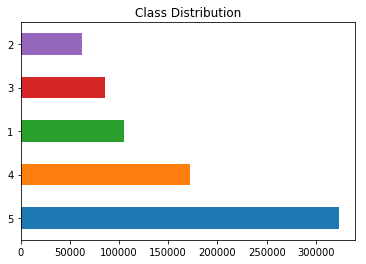

In [8]:
# Class Distribution
df['stars'].value_counts().plot(kind='barh')
plt.title('Class Distribution')

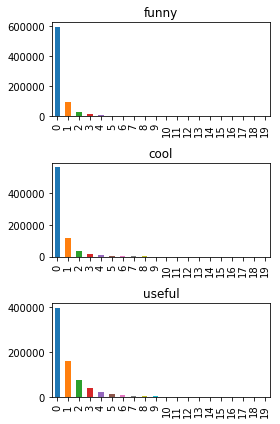

In [9]:
# Distribution of Other Features
catcols = ['funny', 'cool','useful']

plt.figure(figsize=(4,6))
for i,col in enumerate(catcols):
    plt.subplot(311+i)
    df[col].value_counts()[:20].plot(kind='bar')
    plt.title(col)
plt.tight_layout()

## Using Doc2Vec To Vectorize

In [78]:
vmodel = Doc2Vec.load('doc2vec25.model')
ids = df.review_id.values

In [79]:
# Get Vectorized texts
v_data = []
for i in range(len(ids)):
    v = vmodel.docvecs[i]
    v_data.append(v)

In [80]:
v_data = np.vstack(v_data)

In [81]:
fcols  = ['business_id','user_id','year','month','day','dOw','cool','funny','useful']
x_data = df[fcols].values
x_data = np.append(x_data,v_data,axis=-1)
y_data = df['stars'].values

In [82]:
x_data.shape

(749574, 41)

In [83]:
y_data.shape

(749574,)

In [84]:
# Split into Train & Validation
xtrain,xvalid,ytrain,yvalid = train_test_split(x_data,y_data,
                                             test_size=0.33,random_state=32)

print 'Size of Train set: {}'.format(len(xtrain))
print 'Size of Valid set: {}'.format(len(xvalid))

Size of Train set: 502214
Size of Valid set: 247360


## Training & Evaluation

In [92]:
k = 10000

# Training & Evaluation
print '\nTraining & evaluating model...'
# Fit model no training data
model = XGBClassifier(n_estimators=300,njobs=4,
                      objective='multi:softmax',num_class=5)
model.fit(xtrain, ytrain)
ypred = model.predict(xvalid)
ypred = [round(value) for value in ypred]

# evaluate predictions
acc   = accuracy_score(yvalid, ypred)
print("Accuracy: %.2f%%" % (acc * 100.0))


Training & evaluating model...
Accuracy: 62.79%


/home/junior/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([ 41153.,      0.,   9773.,      0.,      0.,  15339.,      0.,
         54419.,      0., 126676.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

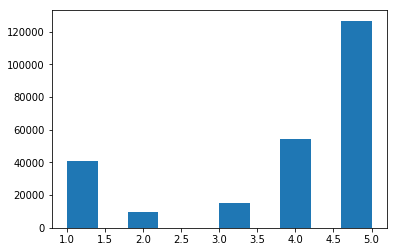

In [93]:
plt.hist(ypred)

(array([1423.,    0.,  818.,    0.,    0., 1088.,    0., 2392.,    0.,
        4279.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

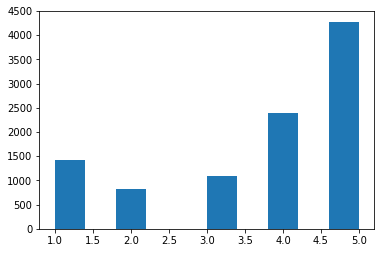

In [94]:
plt.hist(yvalid[:k])